# Vivisection: Steps 1-5

Something weird happened in `01_first_ten_steps.ipynb`. Dead tokens barely moved for the first 4 steps, then suddenly woke up at step 5.

This notebook rips open steps 1-5 and traces *exactly* what happens:

1. **Gradients:** What's ∂L/∂W for dead vs live tokens?
2. **Adam state:** What are m, v, m̂, v̂ at each step?
3. **Updates:** What's the actual weight update before bf16 quantization?
4. **Softmax:** What probability mass lands on dead tokens?

We're doing math to matrices. Let's see the math.

## Parameters

In [9]:
import torch

# Goldilocks reference
GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

# Architecture
N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
DROPOUT = 0.0

# Training
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
MODEL_DTYPE = torch.bfloat16
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

# Reproducibility
RANDOM_SEED = 42

# Experiment
NUM_STEPS = 5

## Imports & Device

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
from tokenizers import Tokenizer
import json
import numpy as np

torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Dtype: {MODEL_DTYPE}")

Device: mps
Dtype: torch.bfloat16


## Load Data

In [11]:
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Tokenizer: {vocab_size:,} tokens")

tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = torch.tensor(census['dead_token_ids'], dtype=torch.long)
live_token_ids = torch.tensor([i for i in range(vocab_size) if i not in census['dead_token_ids']], dtype=torch.long)

# Create boolean mask for easy indexing
dead_mask = torch.zeros(vocab_size, dtype=torch.bool)
dead_mask[dead_token_ids] = True

print(f"✓ Dead tokens: {len(dead_token_ids):,}")
print(f"✓ Live tokens: {len(live_token_ids):,}")

✓ Tokenizer: 3,988 tokens
✓ Corpus: 34,993,926 tokens
✓ Dead tokens: 1,914
✓ Live tokens: 2,074


## Dataset & Model

In [12]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]

class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight  # Weight tying!
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
    
    def forward(self, x, return_hidden=False):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        h = self.ln_f(h)
        logits = self.head(h)
        if return_hidden:
            return logits, h
        return logits

dataset = TokenDataset(all_tokens, SEQ_LEN)
model = GPT(
    vocab_size=vocab_size, d_model=D_MODEL, n_heads=N_HEADS,
    n_layers=N_LAYERS, d_ff=D_FF, seq_len=SEQ_LEN, dropout=DROPOUT
).to(device).to(MODEL_DTYPE)

print(f"✓ Model: {sum(p.numel() for p in model.parameters()):,} parameters")

✓ Model: 1,057,024 parameters


## Training Setup

In [13]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,
    betas=(BETA1, BETA2),
    eps=EPSILON
)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE}, β₁={BETA1}, β₂={BETA2}, ε={EPSILON})")

✓ Optimizer: AdamW (lr=0.001, β₁=0.9, β₂=0.999, ε=1e-08)


## Capture W[0]

In [14]:
W0 = model.tok_emb.weight.detach().clone().cpu()

print(f"W[0] shape: {W0.shape}")
print(f"W[0] dtype: {W0.dtype}")
print(f"\nW[0] statistics (all tokens):")
print(f"  Mean: {W0.float().mean():.6f}")
print(f"  Std: {W0.float().std():.6f}")
print(f"  L2 norms: [{W0.float().norm(dim=1).min():.4f}, {W0.float().norm(dim=1).max():.4f}]")

print(f"\nW[0] dead tokens:")
W0_dead = W0[dead_mask].float()
print(f"  Mean: {W0_dead.mean():.6f}")
print(f"  Std: {W0_dead.std():.6f}")
print(f"  L2 norms: [{W0_dead.norm(dim=1).min():.4f}, {W0_dead.norm(dim=1).max():.4f}]")

W[0] shape: torch.Size([3988, 128])
W[0] dtype: torch.bfloat16

W[0] statistics (all tokens):
  Mean: -0.003233
  Std: 0.999987
  L2 norms: [8.7513, 14.0578]

W[0] dead tokens:
  Mean: -0.003886
  Std: 0.999551
  L2 norms: [8.9815, 14.0578]


---

# The Vivisection

For each step 1-5, we:
1. Run forward pass, get logits and hidden states
2. Compute loss
3. Backward pass - capture gradients
4. Before optimizer.step() - examine what Adam *will* do
5. After optimizer.step() - examine what changed

In [15]:
def analyze_step(step_num, model, optimizer, x, y, dead_mask, live_token_ids, vocab_size, device):
    """Perform one training step with full instrumentation."""

    results = {'step': step_num}

    # Move mask to device for indexing
    dead_mask_dev = dead_mask.to(device)

    # Capture W before
    W_before = model.tok_emb.weight.detach().clone()

    # Forward pass
    optimizer.zero_grad()
    logits, h = model(x, return_hidden=True)

    # Loss (next-token prediction)
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = y[:, :-1].contiguous()  # y is already the target
    loss = F.cross_entropy(shift_logits.view(-1, vocab_size), shift_labels.view(-1))
    results['loss'] = loss.item()

    # Analyze softmax probabilities on dead tokens
    with torch.no_grad():
        # Take one position to analyze
        sample_logits = logits[0, -1, :].float()  # [vocab_size]
        sample_probs = F.softmax(sample_logits, dim=0)

        dead_probs = sample_probs[dead_mask_dev].cpu()
        live_probs = sample_probs[~dead_mask_dev].cpu()

        results['p_dead_mean'] = dead_probs.mean().item()
        results['p_dead_max'] = dead_probs.max().item()
        results['p_live_mean'] = live_probs.mean().item()
        results['p_live_max'] = live_probs.max().item()

    # Analyze h
    h_mean = h.float().mean(dim=(0, 1)).cpu()  # Average over batch and sequence, move to CPU
    results['h_mean_norm'] = h_mean.norm().item()

    # Backward pass
    loss.backward()

    # Capture gradients - move to CPU for analysis
    grad_W = model.tok_emb.weight.grad.detach().cpu().float()
    grad_dead = grad_W[dead_mask]
    grad_live = grad_W[~dead_mask]

    results['grad_dead_l2_mean'] = grad_dead.norm(dim=1).mean().item()
    results['grad_dead_l2_max'] = grad_dead.norm(dim=1).max().item()
    results['grad_live_l2_mean'] = grad_live.norm(dim=1).mean().item()
    results['grad_live_l2_max'] = grad_live.norm(dim=1).max().item()

    # Check gradient direction vs h_mean for dead tokens (both on CPU now)
    sample_grad_dead = grad_dead[0]  # First dead token
    cos_grad_h = F.cosine_similarity(
        sample_grad_dead.unsqueeze(0),
        h_mean.unsqueeze(0)
    ).item()
    results['cos_grad_h'] = cos_grad_h

    # Examine Adam state BEFORE step (for step > 1)
    emb_param = model.tok_emb.weight
    if emb_param in optimizer.state and 'exp_avg' in optimizer.state[emb_param]:
        m = optimizer.state[emb_param]['exp_avg'].detach().cpu().float()
        v = optimizer.state[emb_param]['exp_avg_sq'].detach().cpu().float()

        m_dead = m[dead_mask]
        v_dead = v[dead_mask]

        results['m_dead_l2_mean'] = m_dead.norm(dim=1).mean().item()
        results['v_dead_mean'] = v_dead.mean().item()
    else:
        results['m_dead_l2_mean'] = 0.0
        results['v_dead_mean'] = 0.0

    # Take optimizer step
    optimizer.step()

    # Capture W after
    W_after = model.tok_emb.weight.detach().clone()

    # Compute actual displacement (all on CPU)
    delta_W = (W_after.cpu().float() - W_before.cpu().float())
    delta_dead = delta_W[dead_mask]
    delta_live = delta_W[~dead_mask]

    results['delta_dead_l2_mean'] = delta_dead.norm(dim=1).mean().item()
    results['delta_dead_l2_max'] = delta_dead.norm(dim=1).max().item()
    results['delta_live_l2_mean'] = delta_live.norm(dim=1).mean().item()
    results['delta_live_l2_max'] = delta_live.norm(dim=1).max().item()

    # How many dead tokens actually moved? (L1 > 0 in bf16)
    W_before_bf16 = W_before.cpu()
    W_after_bf16 = W_after.cpu()
    delta_bf16 = (W_after_bf16.float() - W_before_bf16.float())
    dead_moved = (delta_bf16[dead_mask].abs().sum(dim=1) > 0).sum().item()
    results['dead_tokens_moved'] = dead_moved
    results['dead_tokens_total'] = dead_mask.sum().item()

    # Examine Adam state AFTER step (move to CPU)
    m_after = optimizer.state[emb_param]['exp_avg'].detach().cpu().float()
    v_after = optimizer.state[emb_param]['exp_avg_sq'].detach().cpu().float()

    m_dead_after = m_after[dead_mask]
    v_dead_after = v_after[dead_mask]

    results['m_dead_l2_mean_after'] = m_dead_after.norm(dim=1).mean().item()
    results['v_dead_mean_after'] = v_dead_after.mean().item()

    # Manually compute what Adam should have done for dead tokens
    # m_t = β₁ * m_{t-1} + (1 - β₁) * g
    # v_t = β₂ * v_{t-1} + (1 - β₂) * g²
    # m̂_t = m_t / (1 - β₁^t)
    # v̂_t = v_t / (1 - β₂^t)
    # update = lr * m̂ / (√v̂ + ε)

    t = step_num
    bias_correction1 = 1 - BETA1 ** t
    bias_correction2 = 1 - BETA2 ** t

    m_hat_dead = m_dead_after / bias_correction1
    v_hat_dead = v_dead_after / bias_correction2

    expected_update = LEARNING_RATE * m_hat_dead / (torch.sqrt(v_hat_dead) + EPSILON)
    results['expected_update_l2_mean'] = expected_update.norm(dim=1).mean().item()

    return results

In [16]:
# Run the vivisection
model.train()
loader_iter = iter(loader)
all_results = []

for step in range(1, NUM_STEPS + 1):
    try:
        x, y = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        x, y = next(loader_iter)
    
    x, y = x.to(device), y.to(device)
    
    results = analyze_step(step, model, optimizer, x, y, dead_mask, live_token_ids, vocab_size, device)
    all_results.append(results)
    
    print(f"\n{'='*60}")
    print(f"STEP {step}")
    print(f"{'='*60}")
    print(f"Loss: {results['loss']:.4f}")
    print(f"\nSoftmax probabilities:")
    print(f"  p_dead: mean={results['p_dead_mean']:.2e}, max={results['p_dead_max']:.2e}")
    print(f"  p_live: mean={results['p_live_mean']:.2e}, max={results['p_live_max']:.2e}")
    print(f"\nHidden state:")
    print(f"  ||h_mean||: {results['h_mean_norm']:.4f}")
    print(f"\nGradients (L2 norm):")
    print(f"  dead: mean={results['grad_dead_l2_mean']:.2e}, max={results['grad_dead_l2_max']:.2e}")
    print(f"  live: mean={results['grad_live_l2_mean']:.2e}, max={results['grad_live_l2_max']:.2e}")
    print(f"  cos(grad_dead, h_mean): {results['cos_grad_h']:.4f}")
    print(f"\nAdam state (dead tokens):")
    print(f"  ||m||: {results['m_dead_l2_mean_after']:.2e}")
    print(f"  v mean: {results['v_dead_mean_after']:.2e}")
    print(f"  Expected update ||lr * m̂ / (√v̂ + ε)||: {results['expected_update_l2_mean']:.2e}")
    print(f"\nActual displacement (L2 norm):")
    print(f"  dead: mean={results['delta_dead_l2_mean']:.2e}, max={results['delta_dead_l2_max']:.2e}")
    print(f"  live: mean={results['delta_live_l2_mean']:.2e}, max={results['delta_live_l2_max']:.2e}")
    print(f"\nDead tokens that moved (bf16): {results['dead_tokens_moved']} / {results['dead_tokens_total']}")


STEP 1
Loss: 85.5000

Softmax probabilities:
  p_dead: mean=5.04e-21, max=5.45e-18
  p_live: mean=4.82e-04, max=1.00e+00

Hidden state:
  ||h_mean||: 1.7402

Gradients (L2 norm):
  dead: mean=1.80e-10, max=3.07e-07
  live: mean=7.66e-03, max=2.40e-01
  cos(grad_dead, h_mean): 0.0000

Adam state (dead tokens):
  ||m||: 1.81e-11
  v mean: 3.86e-22
  Expected update ||lr * m̂ / (√v̂ + ε)||: 5.43e-06

Actual displacement (L2 norm):
  dead: mean=2.13e-06, max=3.40e-03
  live: mean=2.68e-03, max=1.29e-02

Dead tokens that moved (bf16): 4 / 1914

STEP 2
Loss: 82.5000

Softmax probabilities:
  p_dead: mean=7.46e-25, max=1.43e-21
  p_live: mean=4.82e-04, max=1.00e+00

Hidden state:
  ||h_mean||: 3.0131

Gradients (L2 norm):
  dead: mean=4.58e-10, max=5.06e-07
  live: mean=7.61e-03, max=3.88e-01
  cos(grad_dead, h_mean): 0.0000

Adam state (dead tokens):
  ||m||: 6.21e-11
  v mean: 1.82e-21
  Expected update ||lr * m̂ / (√v̂ + ε)||: 9.87e-06

Actual displacement (L2 norm):
  dead: mean=3.48e-06

## Summary Table

In [17]:
print("\n" + "="*80)
print("SUMMARY: Steps 1-5")
print("="*80)

print(f"\n{'Step':<6} {'Loss':<8} {'grad_dead':<12} {'grad_live':<12} {'Δ_dead':<12} {'Δ_live':<12} {'Moved':<8}")
print("-" * 80)

for r in all_results:
    print(f"{r['step']:<6} {r['loss']:<8.2f} {r['grad_dead_l2_mean']:<12.2e} {r['grad_live_l2_mean']:<12.2e} "
          f"{r['delta_dead_l2_mean']:<12.2e} {r['delta_live_l2_mean']:<12.2e} {r['dead_tokens_moved']:<8}")


SUMMARY: Steps 1-5

Step   Loss     grad_dead    grad_live    Δ_dead       Δ_live       Moved   
--------------------------------------------------------------------------------
1      85.50    1.80e-10     7.66e-03     2.13e-06     2.68e-03     4       
2      82.50    4.58e-10     7.61e-03     3.48e-06     1.79e-03     10      
3      77.50    1.22e-08     7.63e-03     6.48e-06     1.86e-03     22      
4      69.00    1.54e-05     7.70e-03     9.49e-05     1.70e-03     143     
5      57.50    1.21e-04     7.21e-03     3.32e-04     1.81e-03     385     


In [18]:
print("\n" + "="*80)
print("ADAM DYNAMICS")
print("="*80)

print(f"\n{'Step':<6} {'||m_dead||':<14} {'v_dead_mean':<14} {'Expected Δ':<14} {'Actual Δ':<14}")
print("-" * 80)

for r in all_results:
    print(f"{r['step']:<6} {r['m_dead_l2_mean_after']:<14.2e} {r['v_dead_mean_after']:<14.2e} "
          f"{r['expected_update_l2_mean']:<14.2e} {r['delta_dead_l2_mean']:<14.2e}")


ADAM DYNAMICS

Step   ||m_dead||     v_dead_mean    Expected Δ     Actual Δ      
--------------------------------------------------------------------------------
1      1.81e-11       3.86e-22       5.43e-06       2.13e-06      
2      6.21e-11       1.82e-21       9.87e-06       3.48e-06      
3      1.28e-09       1.30e-18       1.89e-05       6.48e-06      
4      1.54e-06       9.57e-13       2.07e-04       9.49e-05      
5      1.34e-05       3.78e-11       6.64e-04       3.32e-04      


In [19]:
print("\n" + "="*80)
print("SOFTMAX ON DEAD TOKENS")
print("="*80)

print(f"\n{'Step':<6} {'p_dead_mean':<14} {'p_dead_max':<14} {'p_live_mean':<14} {'p_live_max':<14}")
print("-" * 80)

for r in all_results:
    print(f"{r['step']:<6} {r['p_dead_mean']:<14.2e} {r['p_dead_max']:<14.2e} "
          f"{r['p_live_mean']:<14.2e} {r['p_live_max']:<14.2e}")


SOFTMAX ON DEAD TOKENS

Step   p_dead_mean    p_dead_max     p_live_mean    p_live_max    
--------------------------------------------------------------------------------
1      5.04e-21       5.45e-18       4.82e-04       1.00e+00      
2      7.46e-25       1.43e-21       4.82e-04       1.00e+00      
3      7.99e-25       1.43e-21       4.82e-04       1.00e+00      
4      7.47e-18       1.27e-14       4.82e-04       1.00e+00      
5      8.53e-18       1.63e-14       4.82e-04       1.00e+00      


## Diagnosis

What's going on? Let's compare expected vs actual...

In [20]:
print("\nDIAGNOSTIC: Expected vs Actual Update")
print("="*60)

for r in all_results:
    expected = r['expected_update_l2_mean']
    actual = r['delta_dead_l2_mean']
    ratio = actual / expected if expected > 0 else 0
    
    print(f"Step {r['step']}: expected={expected:.2e}, actual={actual:.2e}, ratio={ratio:.4f}")


DIAGNOSTIC: Expected vs Actual Update
Step 1: expected=5.43e-06, actual=2.13e-06, ratio=0.3922
Step 2: expected=9.87e-06, actual=3.48e-06, ratio=0.3529
Step 3: expected=1.89e-05, actual=6.48e-06, ratio=0.3436
Step 4: expected=2.07e-04, actual=9.49e-05, ratio=0.4577
Step 5: expected=6.64e-04, actual=3.32e-04, ratio=0.4991


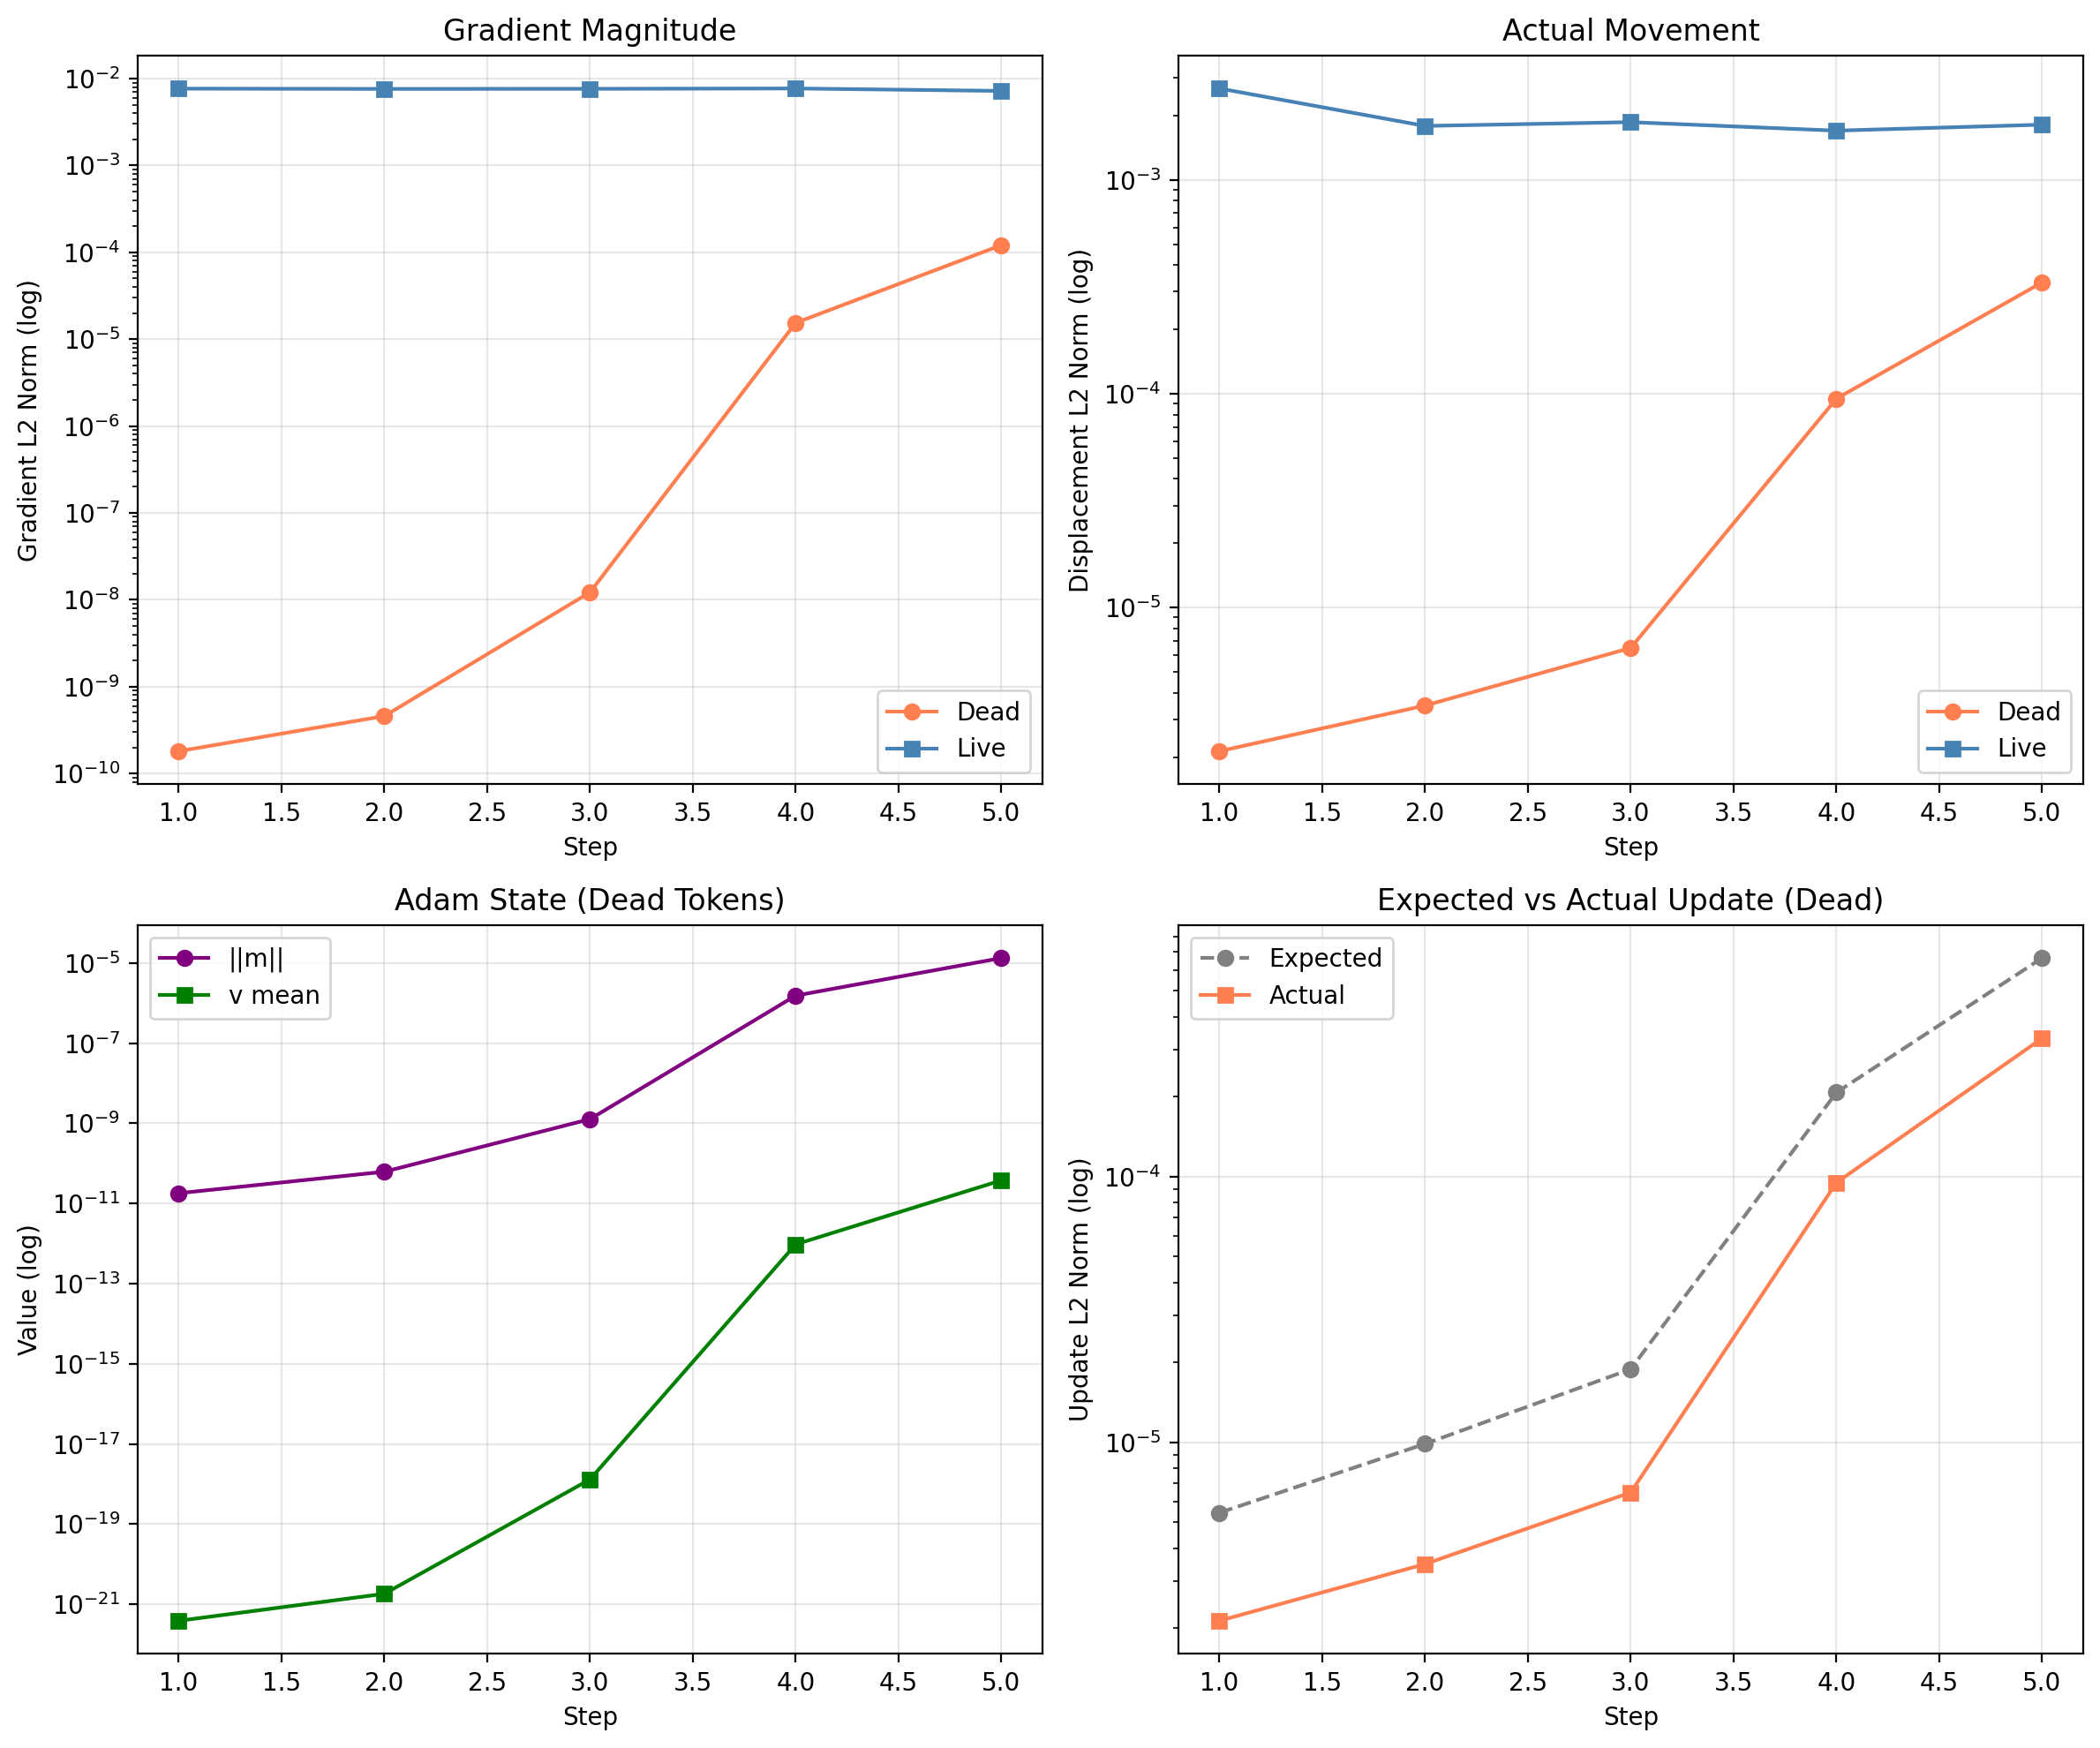


✓ Saved: vivisection@200.png, vivisection@72.png


In [21]:
# Save plots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=200)

steps = [r['step'] for r in all_results]

# Plot 1: Gradients
ax1 = axes[0, 0]
ax1.semilogy(steps, [r['grad_dead_l2_mean'] for r in all_results], 'o-', label='Dead', color='coral')
ax1.semilogy(steps, [r['grad_live_l2_mean'] for r in all_results], 's-', label='Live', color='steelblue')
ax1.set_xlabel('Step')
ax1.set_ylabel('Gradient L2 Norm (log)')
ax1.set_title('Gradient Magnitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Displacements
ax2 = axes[0, 1]
ax2.semilogy(steps, [r['delta_dead_l2_mean'] for r in all_results], 'o-', label='Dead', color='coral')
ax2.semilogy(steps, [r['delta_live_l2_mean'] for r in all_results], 's-', label='Live', color='steelblue')
ax2.set_xlabel('Step')
ax2.set_ylabel('Displacement L2 Norm (log)')
ax2.set_title('Actual Movement')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Adam state
ax3 = axes[1, 0]
ax3.semilogy(steps, [r['m_dead_l2_mean_after'] for r in all_results], 'o-', label='||m||', color='purple')
ax3.semilogy(steps, [r['v_dead_mean_after'] for r in all_results], 's-', label='v mean', color='green')
ax3.set_xlabel('Step')
ax3.set_ylabel('Value (log)')
ax3.set_title('Adam State (Dead Tokens)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Expected vs Actual
ax4 = axes[1, 1]
ax4.semilogy(steps, [r['expected_update_l2_mean'] for r in all_results], 'o--', label='Expected', color='gray')
ax4.semilogy(steps, [r['delta_dead_l2_mean'] for r in all_results], 's-', label='Actual', color='coral')
ax4.set_xlabel('Step')
ax4.set_ylabel('Update L2 Norm (log)')
ax4.set_title('Expected vs Actual Update (Dead)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vivisection@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('vivisection@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Saved: vivisection@200.png, vivisection@72.png")